# 模型推广：基于Voting的超强分类器！

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, explained_variance_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

from sklearn.model_selection import GridSearchCV


import xgboost as xgb
import catboost as cat

# 重采样包
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [12]:
df = pd.read_excel("赛题附件\\附件1.xlsx")
df1 = df[['性别','年龄','身高','体重','ASA','有无手术史','有无既往史',
          '是否吸烟','是否酗酒','有无PONV','有无晕动史' , '镇静药名称',
          
          '呛咳', '体动', '术中其他', 

          '是否出现了恶心呕吐的情况是','是否出现了头晕头昏头痛是',
          '有没出现嗜睡乏力的情况呢有', '有没出现腹胀腹痛的情况呢有','还有没其他不舒服的情况呢有']]

# 删除没必要留下的“ASA”
df2 = df1.drop(['ASA'], axis=1)

# 这个特征比例差别太大了，聚合一下
df2["是否吸烟"] = df2["是否吸烟"].map({"从未吸烟者": '不抽烟', 
                                    "经常吸烟者：每天吸卷烟1支以上，连续或累计6个月": '抽烟',
                                    "偶尔吸烟者：每周吸卷烟超过4次，但平均每天不足1支": '抽烟'})

# 题目取特征太无语了，改一下
df2.columns = ['性别','年龄','身高','体重','有无手术史','有无既往史',
            '是否吸烟','是否酗酒','有无PONV','有无晕动史','镇静药名称',
            '呛咳', '体动', '术中其他',
            '是否恶心呕吐','是否头晕头昏头痛',
            '是否嗜睡乏力','是否腹胀腹痛','有无其他不舒服']

In [13]:
df2['是否恶心呕吐'].fillna('否', inplace=True)
df2['是否头晕头昏头痛'].fillna('否', inplace=True)
df2['是否嗜睡乏力'].fillna('否', inplace=True)
df2['是否腹胀腹痛'].fillna('否', inplace=True)
df2['有无其他不舒服'].fillna('否', inplace=True)

# 数值特征用均值填补缺失值
df2['年龄'].fillna(df1['年龄'].mean(), inplace=True)

In [14]:
# 特征空间:独热编码
X = pd.get_dummies(df2[['性别','年龄','身高','体重','有无手术史','有无既往史',
          '是否吸烟','是否酗酒','镇静药名称']])

# 数据归一化
model = MinMaxScaler()
X[['年龄','身高','体重']] = model.fit_transform(df2[['年龄','身高','体重']])

# 字符串换成数字
df2["呛咳"] = df2["呛咳"].map({"有": 1, "无": 0})
df2["体动"] = df2["体动"].map({"有": 1, "无": 0})
df2["术中其他"] = df2["术中其他"].map({"有": 1, "无": 0})
df2["是否恶心呕吐"] = df2["是否恶心呕吐"].map({"是": 1, "否": 0})
df2["是否头晕头昏头痛"] = df2["是否头晕头昏头痛"].map({"是": 1, "否": 0})
df2["是否嗜睡乏力"] = df2["是否嗜睡乏力"].map({"是": 1, "否": 0})
df2["是否腹胀腹痛"] = df2["是否腹胀腹痛"].map({"是": 1, "否": 0})
df2["有无其他不舒服"] = df2["有无其他不舒服"].map({"是": 1, "否": 0})

In [15]:
# 创建上采样对象
ros = RandomOverSampler(random_state=42)
# 对数据进行上采样
X_resampled, y_resampled = ros.fit_resample(X, df2.呛咳)

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=7)

Model1 = LogisticRegression(max_iter=1000)
Model2 = LinearDiscriminantAnalysis()
Model3 = KNeighborsClassifier()
Model4 = DecisionTreeClassifier()
Model5 = GaussianNB()
Model6 = SVC(probability=True)

Model_plus = VotingClassifier(estimators=[("LR", Model1), ("LDA", Model2),
                            ("KNN", Model3), ("DT", Model4),
                            ("NB", Model5), ("SVM", Model6)],
                            voting="soft")

names = ["LR", "LDA", "KNN", "DT", "NB", "SVM", "Voting"]
model = [Model1, Model2, Model3, Model4, Model5, Model6, Model_plus]
for i in range(0, 7):
    model[i].fit(X1_train, y1_train)
    y1_pred = model[i].predict(X1_test)
    print(names[i], "%.5f" % accuracy_score(y1_pred, y1_test))

LR 0.64570
LDA 0.63941
KNN 0.90985
DT 0.97275
NB 0.61635
SVM 0.66247
Voting 0.90356


In [16]:
# 创建上采样对象
ros = RandomOverSampler(random_state=42)
# 对数据进行上采样
X_resampled, y_resampled = ros.fit_resample(X, df2.呛咳)

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=7)

Model1 = xgb.XGBClassifier(learning_rate=0.1, gamma=0.3, max_depth=10, min_child_weight=1, n_estimators=100)
Model2 = KNeighborsClassifier()
Model3 = DecisionTreeClassifier()

Model_plus = VotingClassifier(estimators=[("XGB", Model1), ("KNN", Model2), ("DT", Model3)], voting="soft")

names = ["XGB", "KNN", "DT", "Voting"]
model = [Model1, Model2, Model3, Model_plus]
for i in range(0, 4):
    model[i].fit(X1_train, y1_train)
    y1_pred = model[i].predict(X1_test)
    print(names[i], "%.5f" % accuracy_score(y1_pred, y1_test))

XGB 0.97904
KNN 0.90985
DT 0.97694
Voting 0.98113


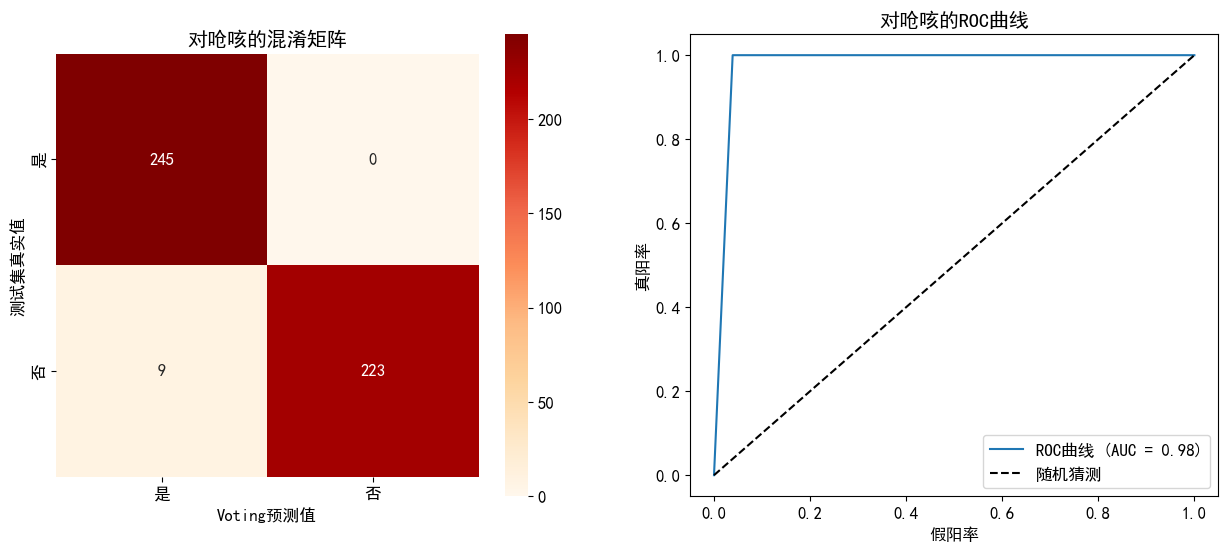

In [17]:
mat1 = confusion_matrix(y1_test, y1_pred, 
                labels=[1, 0])
fpr1, tpr1, thresholds1 = roc_curve(y1_test, y1_pred)
auc1 = roc_auc_score(y1_test, y1_pred)

plt.figure(figsize=(15, 6))

# 形成热力图
plt.subplot(1, 2, 1)
sns.heatmap(mat1, annot=True, square="equal", cmap="OrRd", fmt="d",
    xticklabels=["是", "否"], 
    yticklabels=["是", "否"])
plt.xlabel("Voting预测值")
plt.ylabel("测试集真实值")
plt.title("对呛咳的混淆矩阵")

plt.subplot(1, 2, 2)
# 绘制ROC曲线和y=x的对角线
plt.plot(fpr1, tpr1, label='ROC曲线 (AUC = {:.2f})'.format(auc1))
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测')
plt.xlabel('假阳率')
plt.ylabel('真阳率')
plt.title('对呛咳的ROC曲线')
plt.legend()